### Set Up

In [205]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier as RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.utils import class_weight

In [206]:
# Función para convertir un archivo .parquet a .csv
def convertir_parquet_a_csv(ruta_parquet, ruta_csv):
    try:
        # Leer el archivo .parquet
        datos = pd.read_parquet(ruta_parquet)
        # Guardar el DataFrame en formato .csv
        datos.to_csv(ruta_csv, index=False)
        print(f"Archivo convertido y guardado en {ruta_csv}")
    except Exception as e:
        print(f"Error al convertir el archivo: {e}")

# Ruta del archivo .parquet en Google Drive y la ruta de salida para el .csv
ruta_parquet = './features_cleaned.parquet'  # Cambia esta ruta según la ubicación del archivo .parquet
ruta_csv = './features_cleaned.csv'         # Cambia esta ruta de salida para el archivo .csv

# Llamada a la función
convertir_parquet_a_csv(ruta_parquet, ruta_csv)

Archivo convertido y guardado en ./features_cleaned.csv


In [207]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np

# Ruta de los archivos en tu Drive
features_file = './features_cleaned.csv'
labels_file = './dfcrossmatches_prioritized_v7.0.1.csv'

# Cargar el archivo de características con 'oid' como índice
df_feat = pd.read_csv(features_file, index_col='oid')

# Cargar el archivo de etiquetas con 'oid' como índice
df_labels = pd.read_csv(labels_file, index_col='oid', on_bad_lines='skip')

# Verificar las columnas disponibles en df_labels
print("Columnas en df_labels:", df_labels.columns)

# Verificar si 'classALeRCE' existe en las columnas
if 'classALeRCE' in df_labels.columns:
    # Descartar valores infinitos en df_feat
    df_feat = df_feat.replace([np.inf, -np.inf], np.nan)

    # Imprimir tamaño de la columna de clases y las primeras filas del DataFrame de características
    print(df_labels['classALeRCE'].values.size)
    print(df_feat.head())
else:
    print("La columna 'classALeRCE' no fue encontrada en df_labels.")
    print("Asegúrate de que el archivo tiene esta columna correctamente definida.")


Columnas en df_labels: Index(['classALeRCE', 'ra', 'dec', 'period', 'source', 'id_source',
       'class_source', 'separation_arcsec'],
      dtype='object')
173879
                  gal_b       gal_l  g-r_max_g_r  g-r_mean_g_r  \
oid                                                              
ZTF18aahvndq  84.778146   32.955580    -0.041541      0.246432   
ZTF19abqviuy -56.280179  109.009059    -0.079274      0.021343   
ZTF19acyogrm -24.613587  148.867482     1.280889      0.400809   
ZTF20aaiovoy  42.559095  209.082699     0.178904      0.587743   
ZTF20abcqpdj  72.178184  147.837430     0.308870      0.400827   

              g-r_max_corr_g_r  g-r_mean_corr_g_r        rb  MHPS_ratio_g  \
oid                                                                         
ZTF18aahvndq               NaN                NaN  0.882857    254.265274   
ZTF19abqviuy               NaN                NaN  0.930000     75.107750   
ZTF19acyogrm          1.227327           0.502450  0.850000     

In [208]:
df_labels.value_counts('classALeRCE')

classALeRCE
EB/EW             47541
QSO               40390
RRL               39234
LPV               15992
EA                 9961
AGN                6641
YSO                3572
SNIa               1899
RSCVn              1757
Blazar             1635
CV/Nova            1232
DSCT               1096
Periodic-Other      867
Ceph                786
NLQSO               613
SNII                389
SNIbc               139
SNIIn                51
SLSN                 35
SNIIb                21
NLAGN                13
ZZ                   10
TDE                   5
Name: count, dtype: int64

In [209]:
df_labels['classALeRCE'] = df_labels['classALeRCE'].replace(['SNIIn', 'SNIIb'], 'SNII')

# Verificar el cambio
print(df_labels['classALeRCE'].value_counts())

classALeRCE
EB/EW             47541
QSO               40390
RRL               39234
LPV               15992
EA                 9961
AGN                6641
YSO                3572
SNIa               1899
RSCVn              1757
Blazar             1635
CV/Nova            1232
DSCT               1096
Periodic-Other      867
Ceph                786
NLQSO               613
SNII                461
SNIbc               139
SLSN                 35
NLAGN                13
ZZ                   10
TDE                   5
Name: count, dtype: int64


In [210]:
#defining taxonomy tree according to the taxonomy presented in Section 2.2 of the paper.
df_labels['class_original'] = df_labels['classALeRCE']

#defining the classes included in the RF model

label_order = ['SNIa', 'SNIbc', 'SNII', 'SLSN','QSO','AGN', 'Blazar', 'YSO','CV/Nova',
               'LPV', 'E', 'DSCT', 'RRL', 'CEP','Periodic-Other']

labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]

#defining hierarchical classes:

labels['class_hierachical'] = labels['class_original']

labels.loc[ (labels['class_hierachical'] == 'LPV') | (labels['class_hierachical'] == 'Periodic-Other') | (labels['class_hierachical'] == 'E')  | (labels['class_hierachical'] == 'DSCT') | (labels['class_hierachical'] == 'RRL') | (labels['class_hierachical'] == 'CEP') , 'class_hierachical'] = 'Periodic'

labels.loc[(labels['class_hierachical'] == 'SNIa') | (labels['class_hierachical'] == 'SNIbc') | (labels['class_hierachical'] == 'SNII') | (labels['class_hierachical'] == 'SLSN'), 'class_hierachical'] = 'Transient'

labels.loc[(labels['class_hierachical'] == 'CV/Nova')  |(labels['class_hierachical'] == 'YSO') |     (labels['class_hierachical'] == 'AGN') |  (labels['class_hierachical'] == 'QSO') | (labels['class_hierachical'] == 'Blazar')  , 'class_hierachical'] = 'Stochastic'

cm_classes_hierachical = ['Transient','Stochastic','Periodic']
cm_classes_original = label_order

print(labels['class_hierachical'].values.shape)
labels.head()

(113193,)


,class_original,class_hierachical
oid,,
ZTF19abegncu,AGN,Stochastic
ZTF18acejdhu,AGN,Stochastic
ZTF18acdzene,AGN,Stochastic
ZTF18abwzuzw,AGN,Stochastic
ZTF19abmposz,AGN,Stochastic


In [211]:
# Definir las columnas que deben ser excluidas de la tabla df_nd
rm_nd_cols = [
    'n_det_1', 'n_det_2', 'n_pos_1', 'n_pos_2', 'n_neg_1', 'n_neg_2',
    'first_mag_1', 'first_mag_2', 'MHPS_non_zero_1', 'MHPS_non_zero_2',
    'MHPS_PN_flag_1', 'MHPS_PN_flag_2', 'mean_mag_1', 'mean_mag_2',
    'min_mag_1', 'min_mag_2', 'W1', 'W2', 'W3', 'W4', 'iqr_1', 'iqr_2',
    'delta_mjd_fid_1', 'delta_mjd_fid_2', 'last_mjd_before_fid_1',
    'last_mjd_before_fid_2', 'g-r_ml', 'MHAOV_Period_1', 'MHAOV_Period_2'
]

# Verificar qué columnas de rm_nd_cols no están en df_feat
missing_cols = [col for col in rm_nd_cols if col not in df_feat.columns]

if missing_cols:
    print(f"Las siguientes columnas no se encuentran en df_feat y serán ignoradas: {missing_cols}")

# Eliminar solo las columnas que están presentes
cols_to_drop = [col for col in rm_nd_cols if col in df_feat.columns]

# Unir el DataFrame labels con las características restantes, excluyendo las columnas definidas
df = labels.join(df_feat.drop(cols_to_drop, axis=1), how='inner')

# Reemplazar valores infinitos por NaN
df = df.replace([np.inf, -np.inf], np.nan)

# Copiar DataFrame para entrenamiento y rellenar NaN con -999
df_train = df.copy()
df_train = df_train.fillna(-999)

# Extraer las etiquetas
labels = df[['class_original', 'class_hierachical']]

# Verificar si 'Mean_1', 'Mean_2', 'class_original' y 'class_hierachical' están presentes antes de eliminarlas
cols_to_remove = ['Mean_1', 'Mean_2', 'class_original', 'class_hierachical']
cols_to_remove = [col for col in cols_to_remove if col in df.columns]

# Eliminar las columnas existentes
df.drop(cols_to_remove, axis=1, inplace=True)

# Rellenar los NaN restantes con -999
df = df.fillna(-999)

# Imprimir el número de valores en class_original
print(len(labels['class_original'].values))

# Mostrar las primeras filas del DataFrame final
df.head()


Las siguientes columnas no se encuentran en df_feat y serán ignoradas: ['n_det_1', 'n_det_2', 'n_pos_1', 'n_pos_2', 'n_neg_1', 'n_neg_2', 'first_mag_1', 'first_mag_2', 'MHPS_non_zero_1', 'MHPS_non_zero_2', 'MHPS_PN_flag_1', 'MHPS_PN_flag_2', 'mean_mag_1', 'mean_mag_2', 'min_mag_1', 'min_mag_2', 'W1', 'W2', 'W3', 'W4', 'iqr_1', 'iqr_2', 'delta_mjd_fid_1', 'delta_mjd_fid_2', 'last_mjd_before_fid_1', 'last_mjd_before_fid_2', 'g-r_ml', 'MHAOV_Period_1', 'MHAOV_Period_2']
1823


,gal_b,gal_l,g-r_max_g_r,g-r_mean_g_r,g-r_max_corr_g_r,g-r_mean_corr_g_r,rb,MHPS_ratio_g,MHPS_low_g,MHPS_high_g,...,GP_DRW_tau_g,GP_DRW_sigma_r,GP_DRW_tau_r,sgscore1,W1-W2,W2-W3,g-W2,g-W3,r-W2,r-W3
oid,,,,,,,,,,,,,,,,,,,,,
ZTF19aarphwc,28.433587,77.811324,-0.080040,-0.030871,-999.000000,-999.000000,0.900000,926.190308,7.336081,0.007921,...,160.036277,0.236910,121.588791,0.761167,-999.000,-999.000,-999.000000,-999.000000,-999.00000,-999.00000
ZTF18acenqto,-38.019501,218.826426,-0.032061,0.117119,-0.037329,-0.406273,0.930000,48.875584,0.277011,0.005668,...,1191.222125,2.360263,1018.152344,0.015167,-999.000,-999.000,-999.000000,-999.000000,-999.00000,-999.00000
ZTF18abshezu,-72.966494,72.632636,0.096467,-0.129673,0.098831,-0.108766,0.758333,1358.509155,6.566469,0.004834,...,86.349313,0.243571,71.909902,0.004792,-999.000,-999.000,-999.000000,-999.000000,-999.00000,-999.00000
ZTF19aanesgt,33.430310,150.468865,0.153276,0.080107,-999.000000,-999.000000,0.740000,105.981819,0.279318,0.002636,...,10.120767,0.066081,7.167300,0.907768,-999.000,-999.000,-999.000000,-999.000000,-999.00000,-999.00000
ZTF18acyxnyw,60.433207,129.525097,-0.034018,0.247023,0.017709,0.253078,0.764286,181.867783,1.505945,0.008280,...,123.039151,0.115851,56.375442,0.019583,0.791,4.484,2.035118,6.519118,1.78204,6.26604


In [212]:
#which are the features included in the model?
print(np.array(df.columns))
print(len(np.array(df.columns)))

['gal_b' 'gal_l' 'g-r_max_g_r' 'g-r_mean_g_r' 'g-r_max_corr_g_r'
 'g-r_mean_corr_g_r' 'rb' 'MHPS_ratio_g' 'MHPS_low_g' 'MHPS_high_g'
 'MHPS_non_zero_g' 'MHPS_PN_flag_g' 'MHPS_ratio_r' 'MHPS_low_r'
 'MHPS_high_r' 'MHPS_non_zero_r' 'MHPS_PN_flag_r' 'iqr_g' 'iqr_r'
 'Amplitude_g' 'AndersonDarling_g' 'Autocor_length_g' 'Beyond1Std_g'
 'Con_g' 'Eta_e_g' 'Gskew_g' 'MaxSlope_g' 'Mean_g' 'Meanvariance_g'
 'MedianAbsDev_g' 'MedianBRP_g' 'PairSlopeTrend_g' 'PercentAmplitude_g'
 'Q31_g' 'Rcs_g' 'Skew_g' 'SmallKurtosis_g' 'Std_g' 'StetsonK_g' 'Pvar_g'
 'ExcessVar_g' 'SF_ML_amplitude_g' 'SF_ML_gamma_g' 'IAR_phi_g'
 'LinearTrend_g' 'Amplitude_r' 'AndersonDarling_r' 'Autocor_length_r'
 'Beyond1Std_r' 'Con_r' 'Eta_e_r' 'Gskew_r' 'MaxSlope_r' 'Mean_r'
 'Meanvariance_r' 'MedianAbsDev_r' 'MedianBRP_r' 'PairSlopeTrend_r'
 'PercentAmplitude_r' 'Q31_r' 'Rcs_r' 'Skew_r' 'SmallKurtosis_r' 'Std_r'
 'StetsonK_r' 'Pvar_r' 'ExcessVar_r' 'SF_ML_amplitude_r' 'SF_ML_gamma_r'
 'IAR_phi_r' 'LinearTrend_r' 'delta_mag_f

In [213]:
for idx, cl in enumerate(label_order):
   print(cl, labels['class_original'][labels['class_original']==cl].shape[0])

SNIa 1364
SNIbc 96
SNII 339
SLSN 24
QSO 0
AGN 0
Blazar 0
YSO 0
CV/Nova 0
LPV 0
E 0
DSCT 0
RRL 0
CEP 0
Periodic-Other 0


Counter({'SNIa': 1364, 'SNII': 339, 'SNIbc': 96, 'SLSN': 24})
       number
SNIa     1364
SNII      339
SNIbc      96
SLSN       24


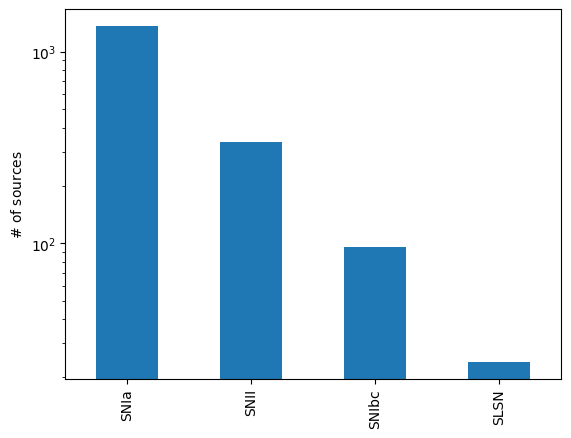

In [214]:
#plotting the number of sources per class for the labeled set
class_counts = Counter(labels['class_original'])
class_counts.most_common()
print(class_counts)


df_hist = pd.DataFrame.from_dict(class_counts, orient='index',columns=['number'])
df_hist = df_hist.sort_values(by=['number'],ascending=False)
print(df_hist)
df_hist.plot(kind='bar',legend=False)


plt.yscale('log')

plt.ylabel(r'$\#$ of sources')

plt.savefig('number_sources_labeled_set.pdf',bbox_inches='tight')

In [215]:
def plot_confusion_matrix(cm, classes, plot_name,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = np.round((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    print(cm)

    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 17)
    plt.yticks(tick_marks, classes, fontsize = 17)

    #fmt = '.2f' if normalize else 'd'
    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%d"%  (cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize = 16)

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 18)
    plt.xlabel('Predicted label',fontsize = 18)
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()



def plot_feature_importances(model, feature_names,feature_importances_name):
    I = np.argsort(model.feature_importances_)[::-1]
    I = I[0:60]
    for i in I[0:30]:
        print(feature_names[i], "& %.3f" % (model.feature_importances_[i]))
    fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
    x_plot = np.arange(len(I))
    plt.xticks(x_plot, [feature_names[i] for i in I], rotation='vertical')
    ax.bar(x_plot, height=model.feature_importances_[I]);
    plt.savefig(feature_importances_name, bbox_inches='tight')
    #plt.close()

### RF

In [216]:
Y_hierarchical = labels['class_hierachical']
Y_original = labels['class_original']

print(len(labels['class_hierachical'].values))
print(len(labels['class_original'].values))
X_hierarchical = df

#splitting training set
X_train_hierarchical, X_test_hierarchical, y_train_hierarchical, y_test_hierarchical, y_train_original, y_test_original  = model_selection.train_test_split(X_hierarchical,
          Y_hierarchical, Y_original, test_size=0.2, stratify=Y_original)


# separating training sets for sub-classes
X_train_periodic = X_train_hierarchical.loc[y_train_hierarchical=='Periodic', :]
y_train_periodic = y_train_original.loc[y_train_hierarchical=='Periodic']

X_train_stochastic = X_train_hierarchical.loc[y_train_hierarchical=='Stochastic', :]
y_train_stochastic = y_train_original.loc[y_train_hierarchical=='Stochastic']

X_train_transient = X_train_hierarchical.loc[y_train_hierarchical=='Transient', :]
y_train_transient = y_train_original.loc[y_train_hierarchical=='Transient']

X_test_periodic = X_test_hierarchical
X_test_stochastic = X_test_hierarchical
X_test_transient = X_test_hierarchical

print(len(y_train_periodic), len(y_train_stochastic), len(y_train_transient))

1823
1823
0 0 1458


In [217]:
import os
import numpy as np

# Crear la carpeta si no existe
os.makedirs('final_BHRF_model', exist_ok=True)

# Guardar los índices
np.save('final_BHRF_model/labels_training_sample.npy', X_train_hierarchical.index.values)
np.save('final_BHRF_model/labels_testint_sample.npy', X_test_hierarchical.index.values)

In [218]:
model_transient_layer = 'rf_model_transient.pkl'  # Nombre del archivo para el modelo
features_pickle = 'features_transient.pkl'  # Nombre del archivo para las características

rf_model_transient = RandomForestClassifier(
            n_estimators=500,
            max_features='sqrt',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_transient.fit(X_train_transient, y_train_transient)

# Applying transient model to the test data
y_true_transient, y_pred_transient  = y_test_original, rf_model_transient.predict(X_test_transient)
y_pred_proba_transient = rf_model_transient.predict_proba(X_test_transient)

classes_order_proba_transient = rf_model_transient.classes_
print(classes_order_proba_transient)

#Dumping trained model

features_transient = list(X_train_transient)

with open(model_transient_layer, 'wb') as f:
            pickle.dump(
                rf_model_transient,
                f,
                pickle.HIGHEST_PROTOCOL)

with open(features_pickle, 'wb') as f:
            pickle.dump(
                features_transient,
                f,
                pickle.HIGHEST_PROTOCOL)

c:\Users\juans\AppData\Local\Programs\Python\Python39\lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\juans\AppData\Local\Programs\Python\Python39\lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


['SLSN' 'SNII' 'SNIa' 'SNIbc']


#### RF: confusion_matrix

SPM_tau_rise_r & 0.028
SPM_gamma_r & 0.023
LinearTrend_r & 0.020
SPM_t0_g & 0.020
MHPS_ratio_g & 0.020
g-r_max_g_r & 0.019
delta_mjd_fid_g & 0.017
SPM_t0_r & 0.017
SPM_tau_rise_g & 0.016
dmag_first_det_fid_g & 0.016
delta_mjd_fid_r & 0.013
SPM_tau_fall_g & 0.013
dmag_first_det_fid_r & 0.013
MHPS_high_g & 0.013
AndersonDarling_r & 0.012
first_mag_r & 0.012
dmag_non_det_fid_r & 0.012
g-r_mean_g_r & 0.011
SPM_tau_fall_r & 0.011
MHPS_low_g & 0.011
SPM_gamma_g & 0.011
LinearTrend_g & 0.010
IAR_phi_r & 0.010
IAR_phi_g & 0.009
MHPS_high_r & 0.009
SPM_beta_r & 0.008
first_mag_g & 0.008
last_diffmaglim_before_fid_g & 0.008
PPE_g_r & 0.008
dmag_non_det_fid_g & 0.008


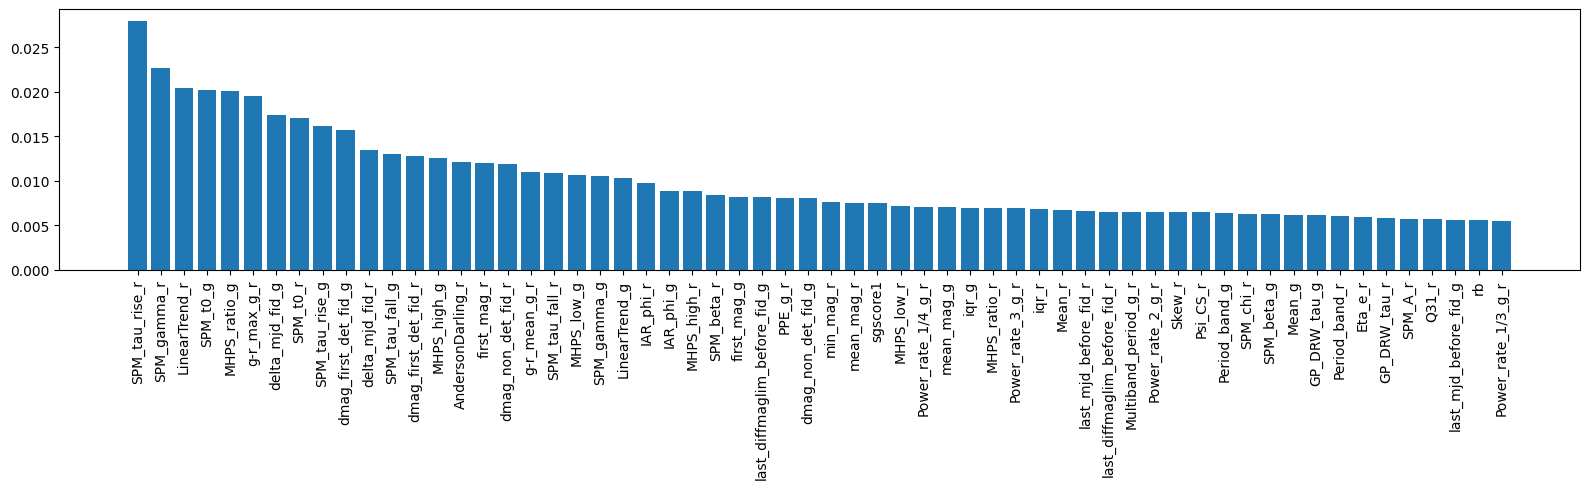

In [219]:
plot_feature_importances(rf_model_transient, features_transient, 'final_BHRF_model/feature_ranking_transient_level.pdf')

Accuracy: 0.62
Balanced accuracy: 0.62
Macro precision: 0.45
Macro recall: 0.62
Macro F1: 0.44
              precision    recall  f1-score   support

        SLSN       0.15      0.80      0.25         5
        SNII       0.62      0.49      0.55        68
        SNIa       0.93      0.66      0.77       273
       SNIbc       0.11      0.53      0.18        19

    accuracy                           0.62       365
   macro avg       0.45      0.62      0.44       365
weighted avg       0.82      0.62      0.69       365

Matriz de confusión normalizada


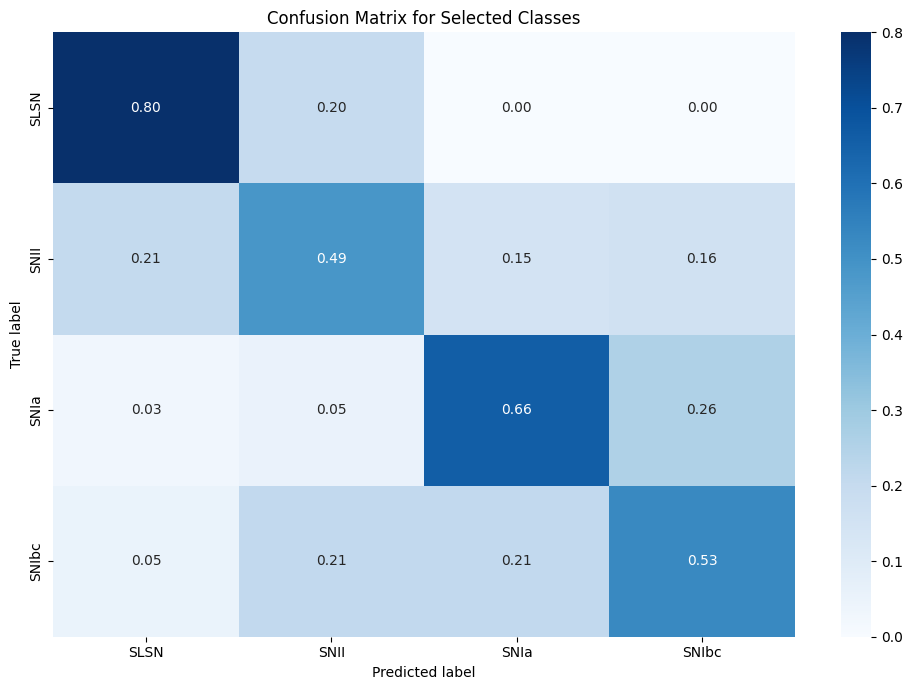

In [226]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, classification_report

# Calcular las métricas globales
accuracy = accuracy_score(y_true_selected, y_pred_selected)
balanced_accuracy = balanced_accuracy_score(y_true_selected, y_pred_selected)
macro_precision = precision_score(y_true_selected, y_pred_selected, average='macro')
macro_recall = recall_score(y_true_selected, y_pred_selected, average='macro')
macro_f1 = f1_score(y_true_selected, y_pred_selected, average='macro')

# Imprimir las métricas globales
print(f"Accuracy: {accuracy:.2f}")
print(f"Balanced accuracy: {balanced_accuracy:.2f}")
print(f"Macro precision: {macro_precision:.2f}")
print(f"Macro recall: {macro_recall:.2f}")
print(f"Macro F1: {macro_f1:.2f}")

# Generar el reporte detallado por clase
report = classification_report(y_true_selected, y_pred_selected, target_names=selected_classes)
print(report)

# Matriz de confusión y otras visualizaciones
cm_selected = confusion_matrix(y_true_selected, y_pred_selected, labels=selected_classes)

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, classes, plot_name='confusion_matrix.pdf', normalize=False, title='Confusion Matrix'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusión normalizada")
    else:
        print("Matriz de confusión sin normalizar")

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(plot_name)
    plt.show()
    
plot_confusion_matrix(cm_selected, classes=selected_classes, plot_name='confusion_matrix_selected_classes.pdf',
                      normalize=True, title='Confusion Matrix for Selected Classes')


### MLP

In [221]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import pickle

from sklearn.preprocessing import LabelEncoder

# y_train_transient y y_test_original son categóricos
label_encoder = LabelEncoder() # se consificarán a numéricos
y_train_encoded = label_encoder.fit_transform(y_train_transient)
y_test_encoded = label_encoder.transform(y_test_original)

# Convertir las etiquetas a tensores para PyTorch
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

# Escalando los datos de entrada N(0,1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_transient)
X_test_scaled = scaler.transform(X_test_transient)

# Convertir los datos de entrada escalados a tensores para PyTorch
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

Ahora etiquetas y vectores de entrada son tensores PyTorch ↑↑↑

In [222]:
# Definir la clase del modelo MLP
class MLPModel(nn.Module): # modelo en PyTorch
    def __init__(self):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(X_train_scaled.shape[1], 100) # primera capa densa (lineal)
        # produce 100 neuronas como salida
        self.fc2 = nn.Linear(100, 50) # Toma lo anterior y produce 50 neuronas como salida
        self.fc3 = nn.Linear(50, len(torch.unique(y_train_tensor))) # produce una salida del 
        # tamaño igual al número de clases en las etiquetas

    def forward(self, x): # se introducen no linealidades
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x) # no tiene activación
        return x

# Inicializar el modelo
model = MLPModel()

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss() # en un problema de clasificación multiclase, 
# la activación se aplica mediante la función de pérdida
optimizer = optim.Adam(model.parameters(), lr=0.001) # obtiene pesos y biases con pasos de 0.001

In [223]:
# Listas para guardar las pérdidas por época
train_losses = []
val_losses = []

# Definir el número de épocas
num_epochs = 50

# Entrenamiento del modelo
for epoch in range(num_epochs):
    model.train()
    
    # Adelante (Forward pass)
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Atrás (Backward pass) y optimización
    loss.backward()
    optimizer.step()
    
    # Guardar la pérdida de entrenamiento
    train_losses.append(loss.item())
    
    # Validación del modelo
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)
        val_losses.append(val_loss.item())
    
    # Imprimir cada 10 épocas
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

Epoch [10/50], Loss: 1.1324, Val Loss: 1.1048
Epoch [20/50], Loss: 0.8300, Val Loss: 0.8085
Epoch [30/50], Loss: 0.6861, Val Loss: 0.7016
Epoch [40/50], Loss: 0.6459, Val Loss: 0.6856
Epoch [50/50], Loss: 0.6165, Val Loss: 0.6559


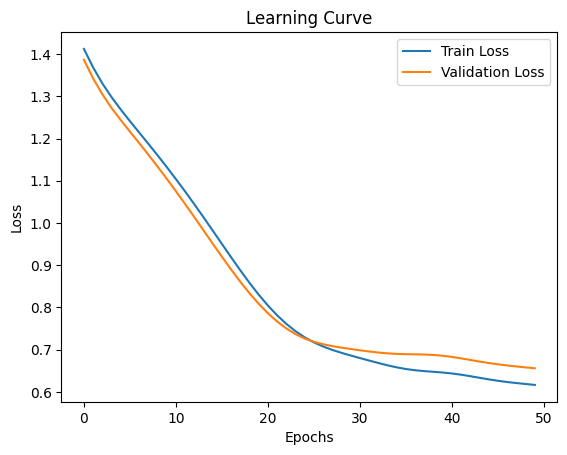

In [224]:
# Graficar la curva de aprendizaje
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

c:\Users\juans\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\juans\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\juans\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Accuracy: 0.78
Balanced accuracy: 0.31
Macro precision: 0.35
Macro recall: 0.31
Macro F1: 0.31
              precision    recall  f1-score   support

        SLSN       0.00      0.00      0.00         5
        SNII       0.59      0.25      0.35        68
        SNIa       0.79      0.98      0.88       273
       SNIbc       0.00      0.00      0.00        19

    accuracy                           0.78       365
   macro avg       0.35      0.31      0.31       365
weighted avg       0.70      0.78      0.72       365

Matriz de confusión normalizada


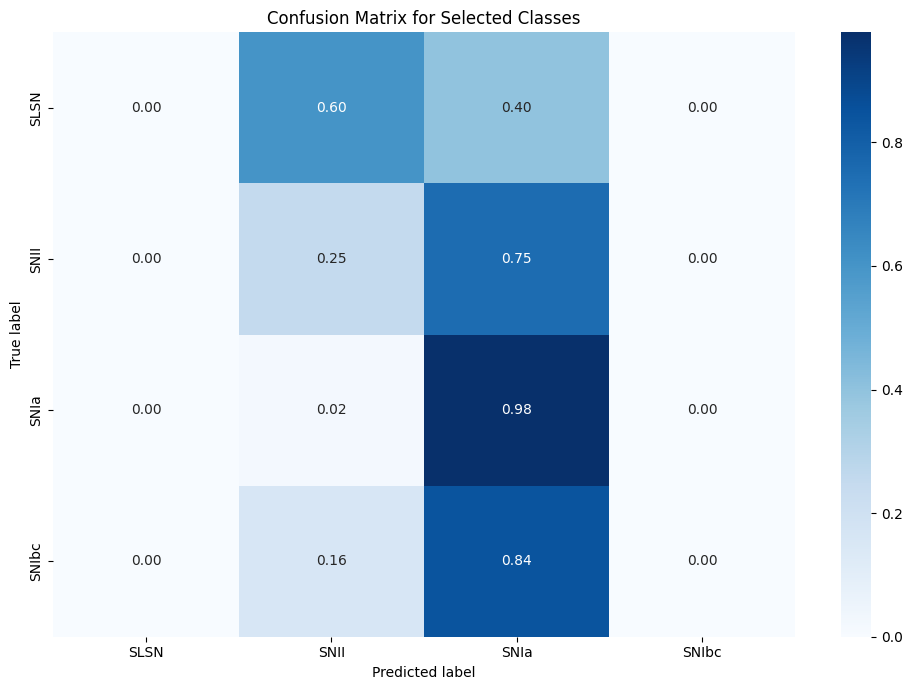

In [228]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Realizar predicciones sobre el conjunto de prueba
model.eval()  # Colocar el modelo en modo evaluación
with torch.no_grad():
    test_outputs = model(X_test_tensor)  # Obtener las predicciones
    _, y_pred_tensor = torch.max(test_outputs, 1)  # Convertir probabilidades en clases

# Convertir los tensores a numpy arrays para las métricas de sklearn
y_pred = y_pred_tensor.cpu().numpy()
y_true = y_test_tensor.cpu().numpy()

# Calcular las métricas globales
accuracy = accuracy_score(y_true, y_pred)
balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
macro_precision = precision_score(y_true, y_pred, average='macro')
macro_recall = recall_score(y_true, y_pred, average='macro')
macro_f1 = f1_score(y_true, y_pred, average='macro')

# Imprimir las métricas globales
print(f"Accuracy: {accuracy:.2f}")
print(f"Balanced accuracy: {balanced_accuracy:.2f}")
print(f"Macro precision: {macro_precision:.2f}")
print(f"Macro recall: {macro_recall:.2f}")
print(f"Macro F1: {macro_f1:.2f}")

# Generar el reporte detallado por clase
selected_classes = label_encoder.classes_  # Obtener los nombres de las clases originales
report = classification_report(y_true, y_pred, target_names=selected_classes)
print(report)

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, classes, plot_name='mlp_confusion_matrix.pdf', normalize=False, title='Confusion Matrix'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusión normalizada")
    else:
        print("Matriz de confusión sin normalizar")

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(plot_name)
    plt.show()

# Graficar la matriz de confusión
plot_confusion_matrix(cm, classes=selected_classes, plot_name='mlp_confusion_matrix_selected_classes.pdf',
                      normalize=True, title='Confusion Matrix for Selected Classes')


#### MLP: Exportar

In [23]:
# Guardar el modelo en formato .pth
model_path = 'mlp_model_transient.pth'
torch.save(model.state_dict(), model_path)
print(f'Modelo guardado en: {model_path}')

Modelo guardado en: mlp_model_transient.pth


In [24]:
# Guardar los parámetros entrenados en trained_parameters.pth
torch.save(model.state_dict(), 'trained_parameters.pth')
print('Parámetros entrenados guardados en: trained_parameters.pth')

Parámetros entrenados guardados en: trained_parameters.pth


#### MLP: Multi-classSVDD

In [234]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score

class MLP_VDD(nn.Module):
    def __init__(self, input_dim, z_dim):
        super(MLP_VDD, self).__init__()
        
        # Arquitectura del encoder
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, z_dim, bias=False)  # espacio latente (de representación enn menor dimensión)
        
    def encode(self, x):
        # Aplicamos las capas con ReLU y normalización por lotes
        h = F.leaky_relu(self.bn1(self.fc1(x)))
        h = F.leaky_relu(self.bn2(self.fc2(h)))
        h = F.leaky_relu(self.bn3(self.fc3(h)))
        return self.fc4(h)
    
    def forward(self, x):
        return self.encode(x)
    
    def set_c(self, dataloader, eps=0.01):
        """Inicializa el centro para la hiperesfera de cada clase"""
        latents, labels = self.get_latent_space(dataloader)
        c = []
        for i in range(len(np.unique(labels))):
            ixs = np.where(labels == i)
            c.append(torch.mean(latents[ixs], dim=0))
        c = torch.stack(c)
        for i in range(len(c)):
            c[i][(abs(c[i]) < eps) & (c[i] < 0)] = -eps
            c[i][(abs(c[i]) < eps) & (c[i] > 0)] = eps
        self.c = c.to(next(self.parameters()).device)  # Asigna al mismo dispositivo del modelo
    
    def get_latent_space(self, dataloader):
        """Obtiene el espacio latente y etiquetas del dataloader para inicialización"""
        latents = []
        labels = []
        with torch.no_grad():
            # Cambiamos el bucle para que espere solo dos valores (x, y)
            for x, y in dataloader:
                x, y = x.to(next(self.parameters()).device).float(), y.long()
                z = self.forward(x)
                latents.append(z.detach().cpu())
                labels.append(y)
        return torch.cat(latents), torch.cat(labels)
        
    def compute_loss(self, x, y):
        """Calcula la pérdida en función de la distancia a los centros de las clases"""
        z = self.forward(x)
        loss = torch.mean(torch.sum((z - self.c[y]) ** 2, dim=1))
        return loss
    
    def compute_anomaly_score(self, x):
        """Calcula el puntaje de anomalía para cada muestra"""
        z = self.forward(x)
        score = torch.min(torch.sum((z.unsqueeze(1) - self.c) ** 2, dim=2), dim=1)[0]
        return score

# Inicialización del modelo
# Definir el número de épocas
num_epochs = 500
input_dim = X_train_scaled.shape[1]  # Dimensión de entrada basada en tus datos
z_dim = 4  # Definir el tamaño del espacio latente
model = MLP_VDD(input_dim, z_dim)

# Definir el optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Inicializar el centro de las clases usando los datos de entrenamiento
# Suponiendo que tienes un dataloader de entrenamiento, donde la función set_c lo utiliza
# Puedes crear un dataloader manualmente o si ya lo tienes, lo pasas aquí
# Ejemplo de creación de un dataloader simple para este caso:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

# Ahora llamamos al método set_c para inicializar los centros de las clases
model.set_c(train_loader)

# Bucle de entrenamiento similar
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    
    # Calcula la pérdida basada en los centros
    loss = model.compute_loss(X_train_tensor, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    # Validación
    model.eval()
    with torch.no_grad():
        val_loss = model.compute_loss(X_test_tensor, y_test_tensor)
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

Epoch [10/500], Loss: 0.0261, Val Loss: 0.0503
Epoch [20/500], Loss: 0.0089, Val Loss: 0.0210
Epoch [30/500], Loss: 0.0064, Val Loss: 0.0089
Epoch [40/500], Loss: 0.0052, Val Loss: 0.0074
Epoch [50/500], Loss: 0.0045, Val Loss: 0.0065
Epoch [60/500], Loss: 0.0040, Val Loss: 0.0063
Epoch [70/500], Loss: 0.0037, Val Loss: 0.0061
Epoch [80/500], Loss: 0.0035, Val Loss: 0.0060
Epoch [90/500], Loss: 0.0033, Val Loss: 0.0059
Epoch [100/500], Loss: 0.0031, Val Loss: 0.0059
Epoch [110/500], Loss: 0.0029, Val Loss: 0.0058
Epoch [120/500], Loss: 0.0028, Val Loss: 0.0058
Epoch [130/500], Loss: 0.0027, Val Loss: 0.0058
Epoch [140/500], Loss: 0.0026, Val Loss: 0.0059
Epoch [150/500], Loss: 0.0024, Val Loss: 0.0059
Epoch [160/500], Loss: 0.0023, Val Loss: 0.0059
Epoch [170/500], Loss: 0.0022, Val Loss: 0.0060
Epoch [180/500], Loss: 0.0022, Val Loss: 0.0060
Epoch [190/500], Loss: 0.0021, Val Loss: 0.0061
Epoch [200/500], Loss: 0.0020, Val Loss: 0.0061
Epoch [210/500], Loss: 0.0019, Val Loss: 0.0062
E

In [235]:
# Después de finalizar el entrenamiento

# Guardar el modelo en formato .pth
model_path = 'SVDDmlp.pth'
torch.save(model.state_dict(), model_path)
print(f'Modelo guardado en: {model_path}')

Modelo guardado en: SVDDmlp.pth


C:\Users\juans\AppData\Local\Temp\ipykernel_2028\2414616579.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('SVDDmlp.pth'))
c:\Users\jua

Accuracy: 0.70
Balanced accuracy: 0.28
Macro precision: 0.21
Macro recall: 0.28
Macro F1: 0.23
              precision    recall  f1-score   support

        SLSN       0.02      0.20      0.03         5
        SNII       0.00      0.00      0.00        68
        SNIa       0.83      0.93      0.88       273
       SNIbc       0.00      0.00      0.00        19

    accuracy                           0.70       365
   macro avg       0.21      0.28      0.23       365
weighted avg       0.62      0.70      0.66       365

Matriz de confusión normalizada


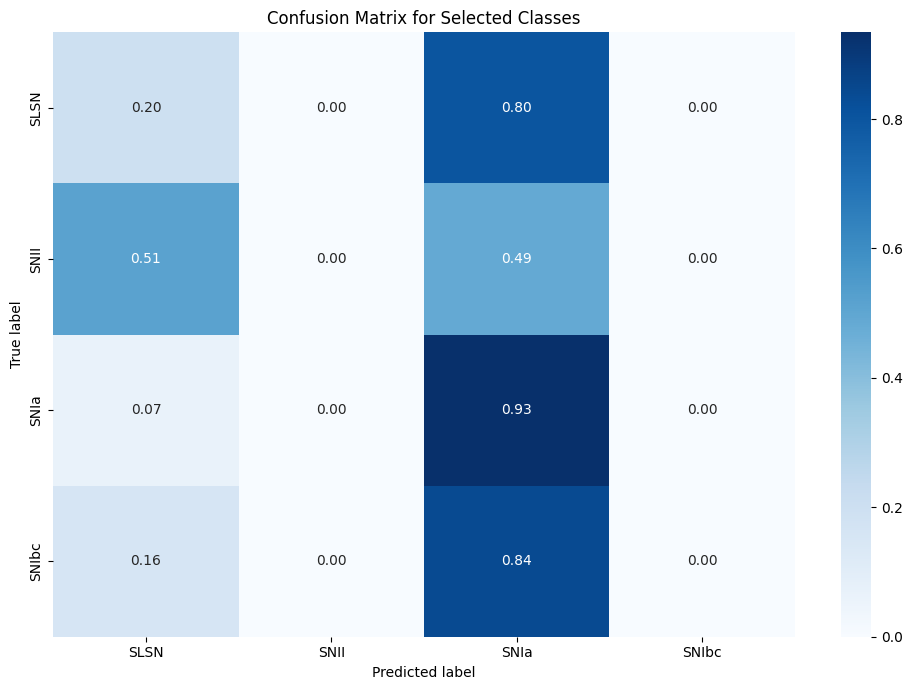

In [236]:
# Cargar el modelo
model = MLP_VDD(input_dim, z_dim)
model.load_state_dict(torch.load('SVDDmlp.pth'))
model.eval()  # Colocar el modelo en modo de evaluación

# Realizar predicciones sobre el conjunto de prueba
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, y_pred_tensor = torch.max(test_outputs, 1)  # Convertir las probabilidades en clases predichas

# Convertir tensores a numpy para usar con sklearn
y_pred = y_pred_tensor.cpu().numpy()
y_true = y_test_tensor.cpu().numpy()

# Calcular las métricas
accuracy = accuracy_score(y_true, y_pred)
balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
macro_precision = precision_score(y_true, y_pred, average='macro')
macro_recall = recall_score(y_true, y_pred, average='macro')
macro_f1 = f1_score(y_true, y_pred, average='macro')

# Imprimir las métricas globales
print(f"Accuracy: {accuracy:.2f}")
print(f"Balanced accuracy: {balanced_accuracy:.2f}")
print(f"Macro precision: {macro_precision:.2f}")
print(f"Macro recall: {macro_recall:.2f}")
print(f"Macro F1: {macro_f1:.2f}")

# Generar el reporte detallado por clase
selected_classes = label_encoder.classes_
report = classification_report(y_true, y_pred, target_names=selected_classes)
print(report)

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, classes, plot_name='mlp_confusion_matrix.pdf', normalize=False, title='Confusion Matrix'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusión normalizada")
    else:
        print("Matriz de confusión sin normalizar")

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(plot_name)
    plt.show()

# Graficar la matriz de confusión
plot_confusion_matrix(cm, classes=selected_classes, plot_name='mlp_confusion_matrix_selected_classes.pdf', 
                      normalize=True, title='Confusion Matrix for Selected Classes')

### Evaluar

#### Evaluar: MLP vs. MLP_VDD

In [27]:
# Inicializar el modelo
model = MLPModel()

# Cargar los parámetros entrenados
model.load_state_dict(torch.load('mlp_model_transient.pth'))
model.eval()

# Evaluar el modelo en el conjunto de prueba
with torch.no_grad():
    predicted = model(X_test_tensor)
    predicted_classes = torch.max(predicted, 1)[1]
    accuracy = accuracy_score(y_test_tensor.numpy(), predicted_classes.numpy())
    print(f'Accuracy en datos de prueba: {accuracy * 100:.2f}%')


Accuracy en datos de prueba: 76.44%


C:\Users\juans\AppData\Local\Temp\ipykernel_2028\3816431611.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('mlp_model_transient.pth'))


In [28]:
# Inicializar el modelo con los argumentos correctos
model = MLP_VDD(input_dim, z_dim)

# Cargar los parámetros entrenados
model.load_state_dict(torch.load('SVDDmlp.pth'))
model.eval()

# Evaluar el modelo en el conjunto de prueba
with torch.no_grad():
    predicted = model(X_test_tensor)
    predicted_classes = torch.max(predicted, 1)[1]
    accuracy = accuracy_score(y_test_tensor.numpy(), predicted_classes.numpy())
    print(f'Accuracy en datos de prueba: {accuracy * 100:.2f}%')

Accuracy en datos de prueba: 74.25%


C:\Users\juans\AppData\Local\Temp\ipykernel_2028\4257881818.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('SVDDmlp.pth'))


C:\Users\juans\AppData\Local\Temp\ipykernel_2028\1636160355.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('SVDDmlp.pth'))
No artists w

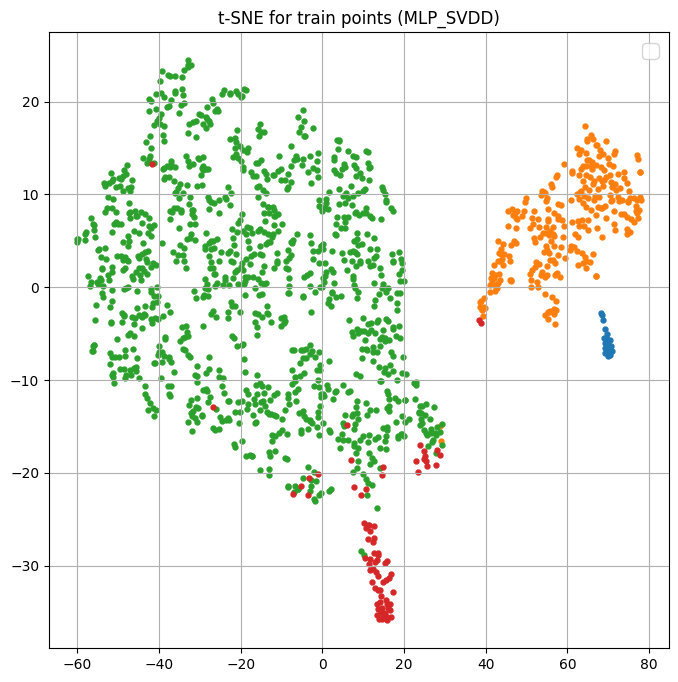

In [237]:
from sklearn.manifold import TSNE

model.load_state_dict(torch.load('SVDDmlp.pth'))
model.eval()  # Poner el modelo en modo de evaluación

# Extraer el espacio latente 
latents_train, labels_train = model.get_latent_space(train_loader)

# Aplicar t-SNE
latents_train_np = latents_train.numpy()  # Convertir a numpy para t-SNE
labels_train_np = labels_train.numpy()

tsne = TSNE(n_components=2, random_state=42)
latents_2d = tsne.fit_transform(latents_train_np)

# Visualizar
plt.figure(figsize=(8,8))
plt.title('t-SNE for train points (MLP_SVDD)')

# Colores
for key in range(len(np.unique(labels_train_np))):
    plt.scatter(latents_2d[:, 0][labels_train_np == key], 
                latents_2d[:, 1][labels_train_np == key], 
                s=50, alpha=1, marker='.')

plt.legend(fontsize=15)
plt.grid(True)
plt.show()